In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('pennines_sin_grad_le_fil.csv')

In [3]:
# Drop rows where 'sinuosity' or 'm_chi' are missing (no data values)
df = df.dropna(subset=['sinuosity', 'm_chi', 'LE'])

In [4]:
# Create 9 quantile bins
df['ksn_bin'] = pd.qcut(df['m_chi'], q=9, labels=False)

# Get the bin ranges (intervals) from qcut
bin_ranges = pd.qcut(df['m_chi'], q=9).cat.categories

# Create a dictionary to map bin numbers to ranges
bin_labels = {i: f"{interval.left:.0f}–{interval.right:.0f}" for i, interval in enumerate(bin_ranges)}

# Calculate midpoints for each bin and store in a dictionary
bin_midpoints = {i: (interval.left + interval.right) / 2 for i, interval in enumerate(bin_ranges)}

# Map the bin numbers to their range labels and midpoints
df['ksn_bin_label'] = df['ksn_bin'].map(bin_labels)
df['ksn_bin_midpoint'] = df['ksn_bin'].map(bin_midpoints)

# Print the 9 gradient bins and their ranges with midpoints
print("Ksn Bins and Their Ranges with Midpoints:")
for bin_num, bin_range in bin_labels.items():
    midpoint = bin_midpoints[bin_num]
    print(f"Bin {bin_num}: {bin_range}, Midpoint: {midpoint:.0f}")


Ksn Bins and Their Ranges with Midpoints:
Bin 0: 0–6, Midpoint: 3
Bin 1: 6–11, Midpoint: 8
Bin 2: 11–15, Midpoint: 13
Bin 3: 15–20, Midpoint: 17
Bin 4: 20–24, Midpoint: 22
Bin 5: 24–28, Midpoint: 26
Bin 6: 28–34, Midpoint: 31
Bin 7: 34–43, Midpoint: 39
Bin 8: 43–129, Midpoint: 86


In [5]:
# Count the number of entries in each bin
print(df['ksn_bin'].value_counts().sort_index())


ksn_bin
0    152
1    152
2    151
3    152
4    151
5    152
6    151
7    152
8    152
Name: count, dtype: int64


In [6]:
# Group by bins and calculate mean sinuosity and lithology
grouped = df.groupby('ksn_bin_midpoint')[['sinuosity', 'LE']].mean()
print(grouped)


                  sinuosity        LE
ksn_bin_midpoint                     
3.11475            1.392260  0.577945
8.49300            1.369163  0.590789
12.70150           1.339715  0.581709
17.14200           1.304027  0.571241
21.87650           1.269816  0.560833
26.15350           1.263185  0.555451
31.03250           1.238162  0.564617
38.53350           1.209974  0.554449
85.96500           1.220938  0.552193


In [8]:
# Save the binned dataset
df.to_csv('pennines_binned_ksn_9.csv', index=False)


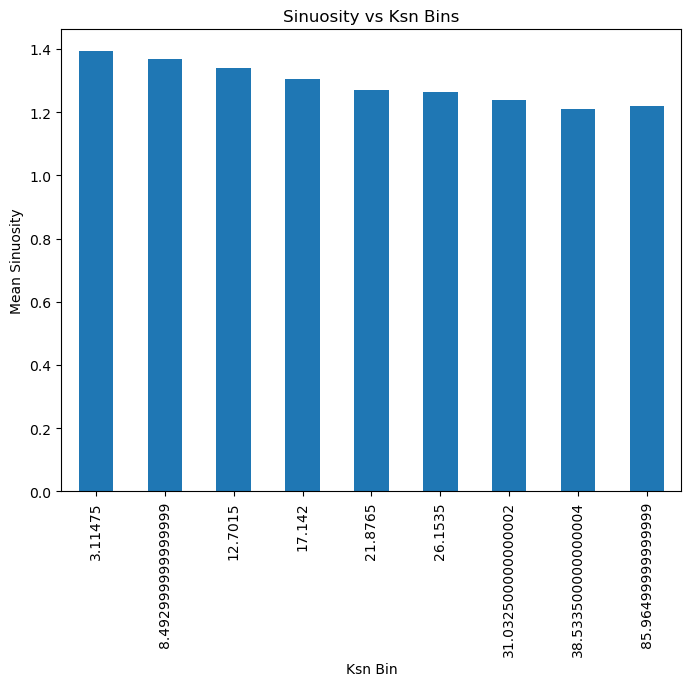

In [7]:

grouped['sinuosity'].plot(kind='bar', figsize=(8, 6))
plt.xlabel('Ksn Bin')
plt.ylabel('Mean Sinuosity')
plt.title('Sinuosity vs Ksn Bins')
plt.show()

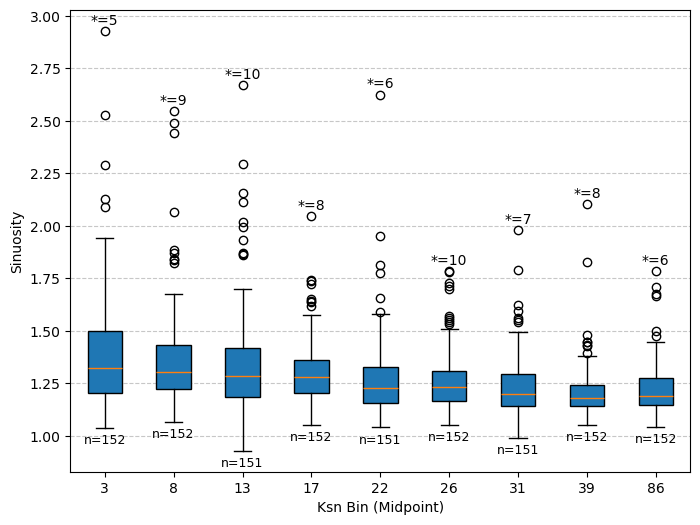

In [29]:
import matplotlib.pyplot as plt

# Prepare data for the box plot
boxplot_data = [
    df[df['ksn_bin'] == bin_number]['sinuosity']
    for bin_number in sorted(df['ksn_bin'].unique())
]

# Get the midpoints for each bin
bin_midpoints = df.groupby('ksn_bin')['ksn_bin_midpoint'].first().sort_index().values

# Get number of points per bin
n_values = [len(data) for data in boxplot_data]

# Create the box plot
plt.figure(figsize=(8, 6))
box = plt.boxplot(boxplot_data, labels=[f"{midpoint:.0f}" for midpoint in bin_midpoints], patch_artist=True)

# Loop through each bin to annotate n-values and outliers
for i, (n, data) in enumerate(zip(n_values, boxplot_data), start=1):
    y_min = min(data) if len(data) > 0 else 0  # Min value for placing n=
    y_max = max(data) if len(data) > 0 else 0  # Max value for placing outlier count

    # Get number of outliers from the fliers data
    num_outliers = len(box["fliers"][i-1].get_ydata())

    # Annotate total points below
    plt.text(i, y_min - 0.075, f"n={n}", ha='center', fontsize=9, color='black')

    # Annotate outliers above
    if num_outliers > 0:  # Only annotate if there are outliers
        plt.text(i, y_max + 0.03, f"*={num_outliers}", ha='center', fontsize=10, color='black')

plt.xlabel('Ksn Bin (Midpoint)')
plt.ylabel('Sinuosity')
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()



In [12]:
import pandas as pd
import numpy as np
from collections import Counter

# Initialize dictionaries to store results
outlier_counts = {i: Counter() for i in range(9)}  # For LE outlier counts
outlier_stats = {}  # For storing the number and percentage of outliers in each bin

# Loop through each gradient_bin
for i in range(9):  # Update the range to include bins 0 to 8
    # Filter data for the current bin
    bin_data = df[df['ksn_bin'] == i]
    
    # Extract sinuosity and LE values for this bin
    sin_data = bin_data['sinuosity']
    le_data = bin_data['LE']
    
    # Calculate the outlier thresholds for sinuosity
    q1 = np.percentile(sin_data, 25)
    q3 = np.percentile(sin_data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Identify outliers based on the thresholds
    outliers = sin_data[(sin_data < lower_bound) | (sin_data > upper_bound)]
    outlier_indices = outliers.index  # Indices of the outliers
    
    # Get corresponding LE values for the outliers
    outlier_LE = le_data.loc[outlier_indices]
    
    # Count the frequency of each LE value and update the Counter
    outlier_counts[i].update(outlier_LE)
    
    # Calculate number of outliers and percentage
    total_points_in_bin = len(bin_data)
    num_outliers = len(outliers)
    percentage_outliers = (num_outliers / total_points_in_bin) * 100 if total_points_in_bin > 0 else 0
    
    # Store stats for the current bin
    outlier_stats[i] = {
        'total_points': total_points_in_bin,
        'num_outliers': num_outliers,
        'percent_outliers': percentage_outliers
    }

# Convert the tally dictionary into a DataFrame
outlier_table = pd.DataFrame.from_dict(outlier_counts, orient='index').fillna(0)

# Convert the stats dictionary into a DataFrame
stats_table = pd.DataFrame.from_dict(outlier_stats, orient='index')

# Display the tables
print("Tally of Outlier LE Values by ksn Bin:")
print(outlier_table)

print("\nOutlier Statistics by ksn Bin:")
print(stats_table)


Tally of Outlier LE Values by ksn Bin:
   0.552381  0.619048  0.638095  0.628571  0.695238
0         3       2.0       0.0       0.0       0.0
1         7       1.0       1.0       0.0       0.0
2         6       2.0       1.0       1.0       0.0
3         5       0.0       0.0       1.0       2.0
4         4       0.0       0.0       2.0       0.0
5         8       2.0       0.0       0.0       0.0
6         5       1.0       0.0       0.0       1.0
7         5       2.0       0.0       1.0       0.0
8         3       1.0       0.0       2.0       0.0

Outlier Statistics by ksn Bin:
   total_points  num_outliers  percent_outliers
0           152             5          3.289474
1           152             9          5.921053
2           151            10          6.622517
3           152             8          5.263158
4           151             6          3.973510
5           152            10          6.578947
6           151             7          4.635762
7           152          

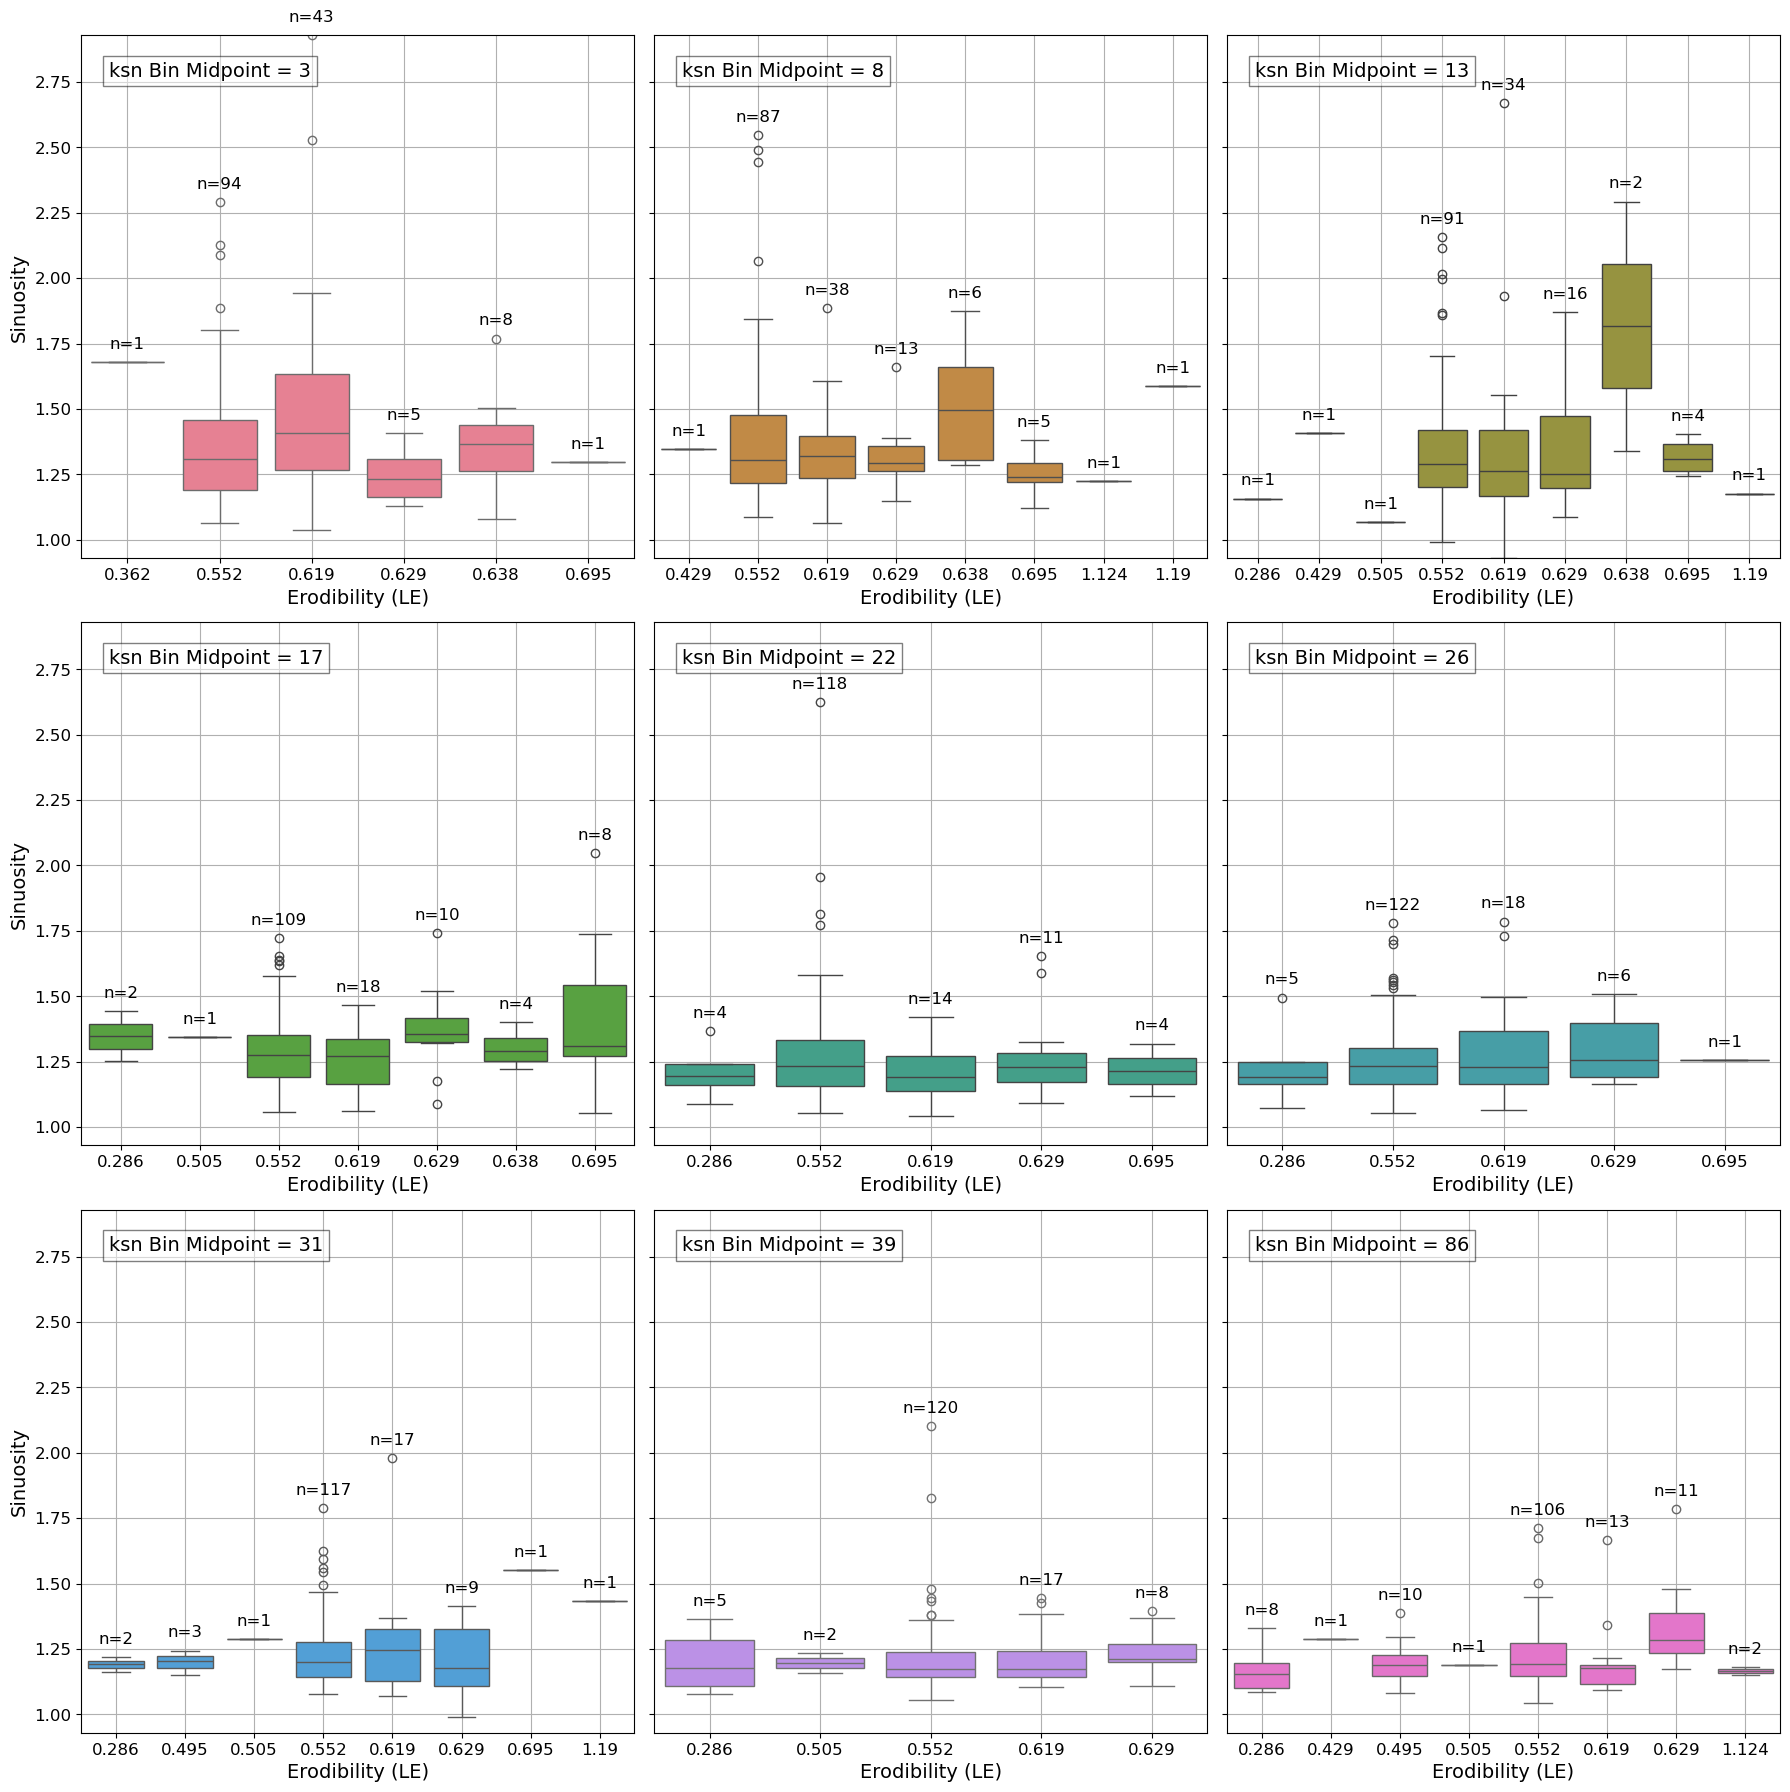

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = 'pennines_binned_ksn_9.csv'
data = pd.read_csv(file_path)

# Drop rows with NaN in the 'LE' column
data = data.dropna(subset=['LE'])

# Format LE to three decimal places for consistent display
data['LE'] = data['LE'].round(3)

# Get unique ksn bins and assign colors
ksn_bins = sorted(data['ksn_bin'].unique())  # Change to ksn_bin
palette = sns.color_palette('husl', len(ksn_bins))  # Use a categorical palette
color_map = {bin: palette[i] for i, bin in enumerate(ksn_bins)}

# Determine global y-axis limits for sinuosity
y_min = data['sinuosity'].min()
y_max = data['sinuosity'].max()

# Create a figure with subplots arranged in a 3x3 grid, sharing the y-axis
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharey=True)

for i, ksn_bin in enumerate(ksn_bins):  # Loop through ksn bins
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Filter data for the current ksn_bin
    subset = data[data['ksn_bin'] == ksn_bin]
    
    # Create a box plot
    box_plot = sns.boxplot(
        x='LE', 
        y='sinuosity', 
        data=subset, 
        ax=ax, 
        color=color_map[ksn_bin]
    )
    
    # Annotate with the number of points for each LE group
    le_counts = subset['LE'].value_counts().sort_index()
    for j, le in enumerate(le_counts.index):
        n = le_counts[le]
        y_pos = subset[subset['LE'] == le]['sinuosity'].max()
        ax.text(j, y_pos + 0.02 * (y_max - y_min), f'n={n}', 
                ha='center', va='bottom', fontsize=12, color='black')

    # Set the same y-axis scale for all plots
    ax.set_ylim(y_min, y_max)
    
    # Title with the ksn bin midpoint
    midpoint = subset['ksn_bin_midpoint'].iloc[0] if not subset.empty else 0
    ax.text(0.05, 0.95, f'ksn Bin Midpoint = {midpoint:.0f}', transform=ax.transAxes, 
            fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    
    # Add xlabel to each plot
    ax.set_xlabel('Erodibility (LE)', fontsize=14)
        
    # Add ylabel only to the first column
    if col == 0:
        ax.set_ylabel('Sinuosity', fontsize=14)
    
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the figure to an SVG file
plt.savefig('sinuosity_vs_erodibility_ksn_box.svg', format='svg', dpi=800)
plt.show()
